# U-Net Model

## Import Libraries, Modules, & Scripts

In [1]:
import torch
import torchmetrics
import numpy as np
import matplotlib.pyplot as plt

from torch import optim, nn
from torchmetrics.classification import BinaryJaccardIndex
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from tqdm import tqdm

from unet import unet
from dataset import dataset
from callbacks import EarlyStopping

## Set Hyperparameters and Device

In [2]:
LEARNING_RATE = 0.001
BATCH_SIZE = 16
EPOCHS = 25
DATA_PATH = '25-ds-casia-un-tvt'
MODEL_SAVE_PATH = 'un-model/ds4-un-model.pth'
RESUME_TRAINING = True

### Select Device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Create Datasets and DataLoaders

In [4]:
train_dataset = dataset(root_path=DATA_PATH, split='train')
val_dataset = dataset(root_path=DATA_PATH, split='validation')
test_dataset = dataset(root_path=DATA_PATH, split='test')

In [5]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Initialize Model, Optimizer, and Loss Function

### Class Weighting

In [6]:
total_px = 0
total_tp_px = 0

In [7]:
for img, mask in train_dataloader:
    total_px += mask.nelement()
    total_tp_px += mask.sum().item()

# Calculate the ratio
au_px = total_px - total_tp_px
pos_weight = au_px / total_tp_px

In [8]:
# Manually adjust pos_weight
pos_weight = 5.75

In [12]:
print(f"Total pixels: {total_px}")                   # 58,851,328
print(f"Total tampered pixels: {total_tp_px:.2f}")   # 6,278,795.00
print(f"Calculated pos_weight: {pos_weight:.2f}")    # 8.37 / or manually set

Total pixels: 58851328
Total tampered pixels: 6278795.00
Calculated pos_weight: 5.75


In [13]:
pos_weight_tensor = torch.tensor([pos_weight]).to(device)

In [14]:
model = unet(in_channels=3, num_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=2)

## Loading Weights and Callbacks

### Initializing Callbacks

In [15]:
cb_es = EarlyStopping(patience=5, path=MODEL_SAVE_PATH, verbose=True)

### Loading Weights

In [17]:
if RESUME_TRAINING:
    try:
        model.load_state_dict(torch.load(MODEL_SAVE_PATH))
        print("Loaded model weights from checkpoint.")
        initial_best_loss = 0.8139 # Replace with actual value if you have it saved
        cb_es.set_initial_best(initial_best_loss)
        print(f"Initial loss: {initial_best_loss:.4f}")
    except FileNotFoundError:
        print("No checkpoint found. Starting training from scratch.")

Loaded model weights from checkpoint.
Initial loss: 0.8139


## Training & Validation Loop

### Lists to Store Evaluation Metrics

In [18]:
# Loss
list_train_loss = []
list_val_loss = []

# Mean Pixel Accuracy (MPA)
list_train_mpa = []
list_val_mpa = []

# Mean IoU
list_train_iou = []
list_val_iou = []

In [19]:
jaccard = BinaryJaccardIndex().to(device)

### Training Loop

In [20]:
for epoch in range(EPOCHS):
    # Training loop
    model.train()
    train_running_loss = 0
    train_mpa_total = 0
    train_mpa_correct = 0
    train_running_iou = 0

    for idx, img_mask in enumerate(tqdm(train_dataloader)):
        img = img_mask[0].float().to(device)
        mask = (img_mask[1].float().to(device) > 0.5).float()

        y_pred = model(img)
        optimizer.zero_grad()

        loss = criterion(y_pred, mask)
        train_running_loss += loss.item()

        loss.backward()
        optimizer.step()

        predicted = (torch.sigmoid(y_pred) > 0.5).float()
        train_mpa_total += mask.nelement()
        train_mpa_correct += (predicted == mask).sum().item()
        train_running_iou += jaccard(predicted, mask).item()

    train_loss = train_running_loss / (idx + 1)
    train_mpa = 100 * train_mpa_correct / train_mpa_total
    train_iou = 100* train_running_iou / len(train_dataloader)

    list_train_loss.append(train_loss)
    list_train_mpa.append(train_mpa)
    list_train_iou.append(train_iou)

    # Validation loop
    model.eval()
    val_running_loss = 0
    val_mpa_total = 0
    val_mpa_correct = 0
    val_running_iou = 0

    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader)):
            img = img_mask[0].float().to(device)
            mask = (img_mask[1].float().to(device) > 0.5).float()

            y_pred = model(img)
            loss = criterion(y_pred, mask)
            val_running_loss += loss.item()

            predicted = (torch.sigmoid(y_pred) > 0.5).float()
            val_mpa_total += mask.nelement()
            val_mpa_correct += (predicted == mask).sum().item()
            val_running_iou += jaccard(predicted, mask).item()

        val_loss = val_running_loss / (idx + 1)
        val_mpa = 100 * val_mpa_correct / val_mpa_total
        val_iou = 100 * val_running_iou / len(val_dataloader)

    list_val_loss.append(val_loss)
    list_val_mpa.append(val_mpa)
    list_val_iou.append(val_iou)

    # Step the scheduler
    scheduler.step(val_loss)

    print("-" * 75)
    print(f"EPOCH {epoch + 1}")
    print(f"Training Evaluation Metrics:\n"
          f"Mean PA: {train_mpa:.4f}% | Mean IoU: {train_iou:.4f}% | Loss: {train_loss:.4f}")
    print(f"Validation Evaluation Metrics:\n"
          f"Mean PA: {val_mpa:.4f}% | Mean IoU: {val_iou:.4f}% | Loss: {val_loss:.4f}")
    print("-" * 75)

    cb_es(val_loss, model)
        
    if cb_es.early_stop:
        print("EarlyStopping: Validation loss did not improve.")
        print("-" * 75)
        break

    if cb_es.early_stop:
        break
    print("-" * 75)

  2%|█▍                                                                                 | 1/57 [00:13<12:18, 13.18s/it]


KeyboardInterrupt: 

### Evaluation Metrics Visualization

#### Mean Pixel Accuracy (Mean PA)

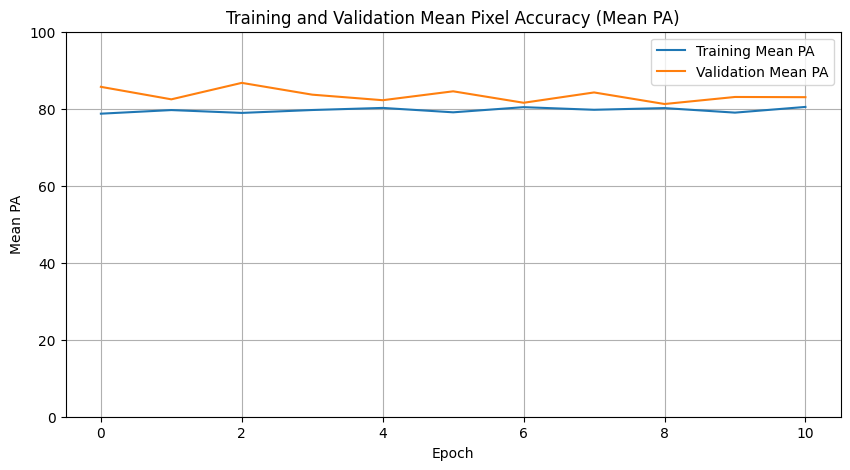

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(list_train_mpa, label='Training Mean PA')
plt.plot(list_val_mpa, label='Validation Mean PA')
plt.title('Training and Validation Mean Pixel Accuracy (Mean PA)')
plt.xlabel('Epoch')
plt.ylabel('Mean PA')
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.show()

#### Loss

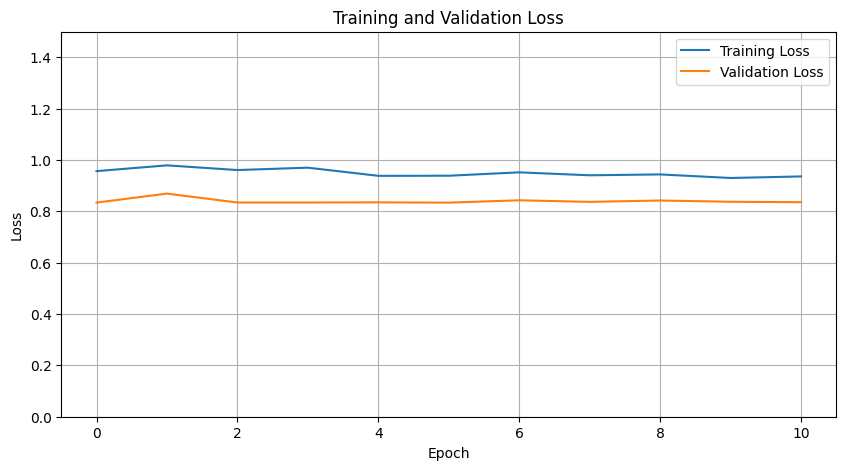

In [40]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(list_train_loss, label='Training Loss')
plt.plot(list_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1.5)
plt.legend()
plt.grid(True)
plt.show()

#### Jaccard Index (IoU)

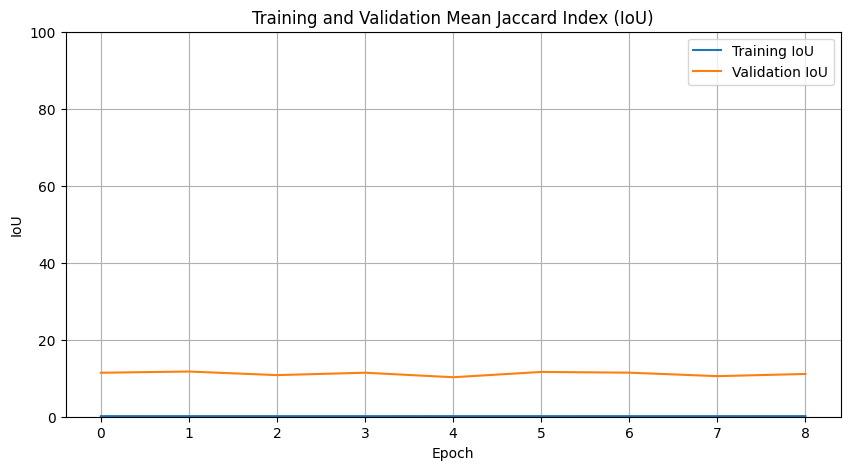

In [29]:
# Plot Training and Validation IoU
plt.figure(figsize=(10, 5))
plt.plot(list_train_iou, label='Training IoU')
plt.plot(list_val_iou, label='Validation IoU')
plt.title('Training and Validation Mean Jaccard Index (IoU)')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.show()

### Save the Model

In [60]:
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to un-model/ds4-un-model.pth


## Test Loop

### Lists to Store Evaluation Metrics

In [ ]:
# Loss
list_test_loss = []

# Mean Pixel Accuracy (MPA)
list_test_mpa = []

# Mean IoU
list_test_iou = []

### Test Loop

In [10]:
# Test loop
model.eval()
test_running_loss = 0
test_mpa_total = 0
test_mpa_correct = 0
test_running_iou = 0
test_running_dice = 0

with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(test_dataloader)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = model(img)
        loss = criterion(y_pred, mask)

        test_running_loss += loss.item()

        # Calculate accuracy for binary segmentation
        predicted = (torch.sigmoid(y_pred) > 0.5).float()
        test_mpa_total += mask.nelement()
        test_mpa_correct += (predicted == mask).sum().item()

        # Calculate IoU for testing
        test_running_iou += jaccard(predicted, mask).item()


# Calculating test metrics
test_loss = test_running_loss / (idx + 1)
test_mpa = 100 * test_mpa_correct / test_mpa_total
test_iou = test_running_iou / len(test_dataloader)

# Appending to lists
list_test_loss.append(test_loss)
list_test_mpa.append(test_mpa)
list_test_iou.append(test_iou)

print("-" * 35)
print(f"Test Evaluation Metrics:\n"
      f"Mean Pixel Accuracy: {test_mpa:.4f}%\n"
      f"IoU: {test_iou:.4f}\n"
      f"Loss: {test_loss:.4f}")
print("-" * 35)

  0%|                                                                                            | 0/8 [00:05<?, ?it/s]


KeyboardInterrupt: 

### Evaluation Metrics Visualization

#### Mean Pixel Accuracy (Mean PA)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(list_test_mpa, label='Test MPA')
plt.title('Test Mean Pixel Accuracy (MPA)')
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.legend()
plt.show()

#### Loss

In [ ]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(list_test_loss, label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Jaccard Index (IoU)

In [ ]:
# Plot Training and Validation IoU
plt.figure(figsize=(10, 5))
plt.plot(list_test_iou, label='Training IoU')
plt.title('Test Mean Jaccard Index (IoU)')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()

#### Dice Coefficient

In [ ]:
# Plot Training and Validation IoU
plt.figure(figsize=(10, 5))
plt.plot(list_test_dice, label='Training Dice')
plt.title('Test Mean Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.show()